# Derivatives Analytics - Options Greeks

**Author**: [Gabriele Pompa](https://www.linkedin.com/in/gabrielepompa/): gabriele.pompa@unisi.com

# Table of contents

[Executive Summary](#executive-summary)

**TODO**

### **Resources**: 

- [_Python for Finance (2nd ed.)_](http://shop.oreilly.com/product/0636920117728.do): Chapter 6 Object-Oriented Programming.


- [Object-Oriented Programming in Python](https://python-textbok.readthedocs.io/en/1.0/index.html): From [Errors and exceptions](https://python-textbok.readthedocs.io/en/1.0/Errors_and_Exceptions.html): Errors and Handling exceptions sections. From [Functions](https://python-textbok.readthedocs.io/en/1.0/Functions.html): up to `*args` and `**kwargs` section. Section [Object-oriented programming](https://python-textbok.readthedocs.io/en/1.0/Object_Oriented_Programming.html)

# Executive Summary <a name="executive-summary"></a>

**TODO**

The following sections are organized as follows:

**TODO**

These are the basic imports

In [1]:
# for NumPy arrays
import numpy as np

# for Pandas Series and DataFrame
import pandas as pd

# for statistical functions
from scipy import stats

# for Matplotlib plotting
import matplotlib.pyplot as plt

# to do inline plots in the Notebook
%matplotlib inline

# for Operating System operations
import os

# for some mathematical functions
import math

# for date management
import datetime as dt

# to identify iterable data-structures
from collections.abc import Iterable

In [2]:
import os, sys
sys.path.insert(0, os.path.abspath('../pyBlackScholesAnalytics'))

In [3]:
from portfolio.portfolio import Portfolio

In [4]:
Portfolio

portfolio.portfolio.Portfolio

In [5]:
from options.options import EuropeanOption

In [6]:
EuropeanOption

options.options.EuropeanOption

## numerical derivative example $sin(x)$

In [7]:
from utils.utils import plot_compare

In [8]:
x = np.linspace(0, 2*math.pi, 100)

In [9]:
def df_dx(f, x0, eps):
    return (f(x0 + eps) - f(x0 - eps))/(2*eps)

In [10]:
# numerical derivative of sin(x)
f_num_deriv = df_dx(f=np.sin, x0=x, eps=1e-10)

# exact derivative of sin(x): cos(x)
f_exact_deriv = np.cos(x)

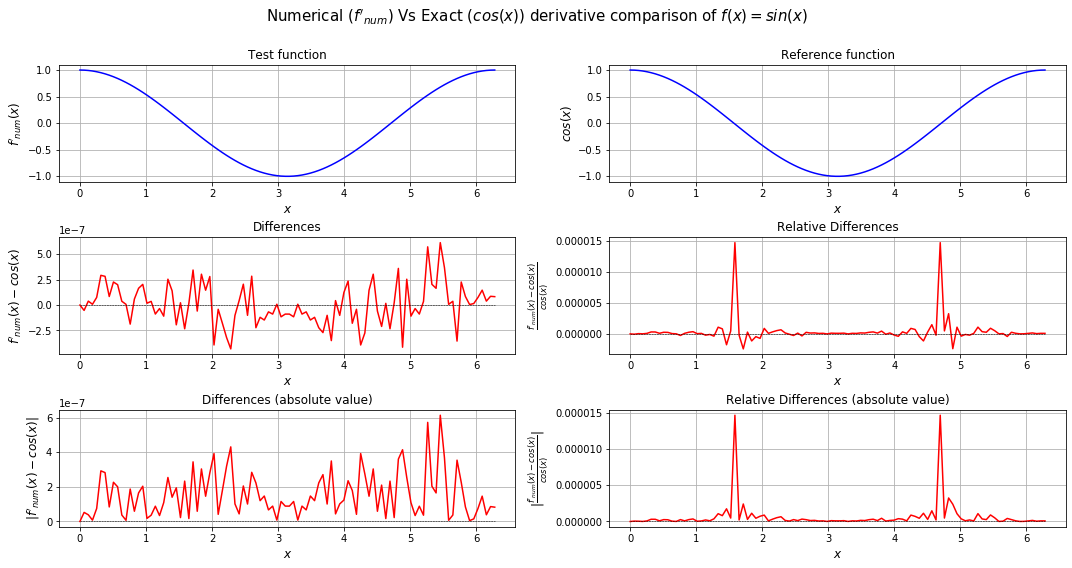

In [11]:
plot_compare(x, f=f_num_deriv, f_ref=f_exact_deriv, 
             f_label=r"f'_{num}(x)", f_ref_label=r"cos(x)",
             title=r"Numerical ($f'_{num}$) Vs Exact ($cos(x)$) derivative comparison of $f(x)=sin(x)$")

# `NumericalGreeks` class

In [12]:
from market.market import MarketEnvironment

In [13]:
mkt_env = MarketEnvironment()

Initializing the MarketEnvironment!


In [14]:
from options.options import PlainVanillaOption

In [15]:
Vanilla_Call = PlainVanillaOption(mkt_env)

Initializing the EuropeanOption!


In [16]:
from utils.numerical_routines import NumericalGreeks

In [17]:
NumGreeks = NumericalGreeks(Vanilla_Call)

In [18]:
S = np.linspace(50, 150, 2000)

In [19]:
delta_numerical = NumGreeks.delta(S0=S)

In [20]:
from utils.utils import plot

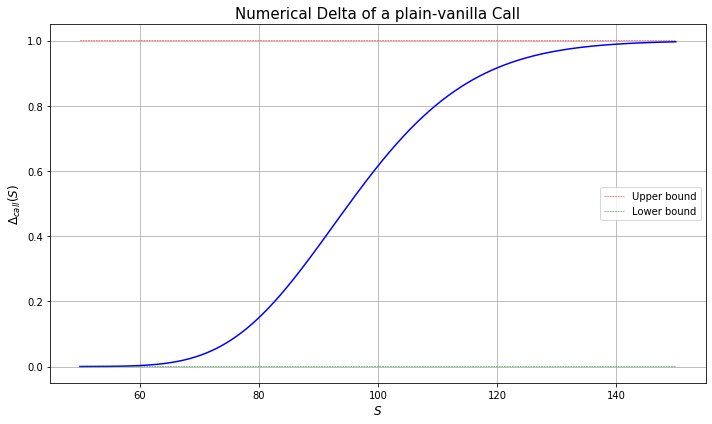

In [21]:
plot(x=S, f=delta_numerical, x_label=r"$S$", f_label=r"$\Delta_{call}(S)$", 
     f_up=np.ones(len(S)), f_up_label=r"Upper bound",
     f_down=np.zeros(len(S)), f_down_label=r"Lower bound",
     title=r"Numerical Delta of a plain-vanilla Call")

In [22]:
theta_numerical = NumGreeks.theta(S=S)

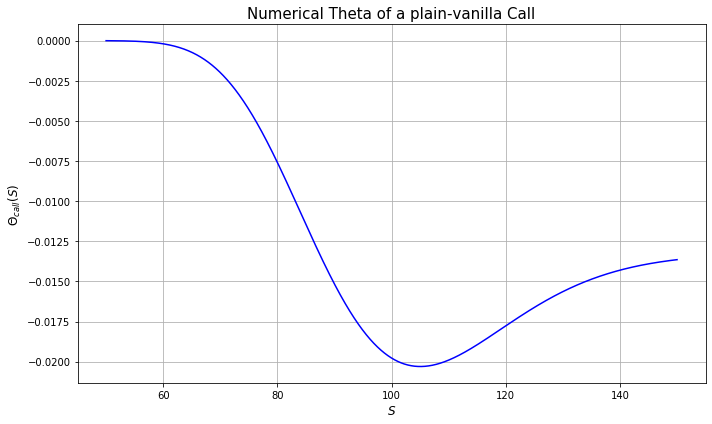

In [23]:
plot(x=S, f=theta_numerical, x_label=r"$S$", f_label=r"$\Theta_{call}(S)$", 
     title=r"Numerical Theta of a plain-vanilla Call")

In [24]:
gamma_numerical = NumGreeks.gamma(S0=S)

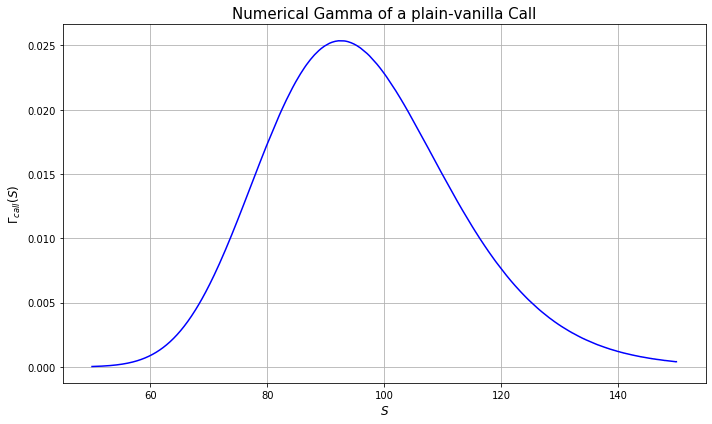

In [25]:
plot(x=S, f=gamma_numerical, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
     title=r"Numerical Gamma of a plain-vanilla Call")

reducing $\epsilon$ does not guarantee increased accuracy

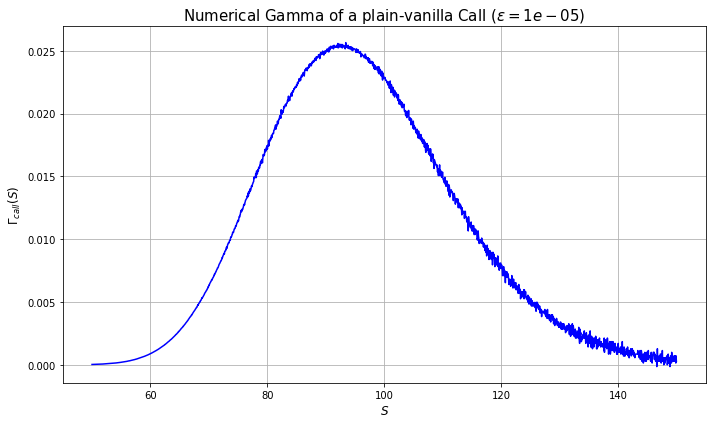

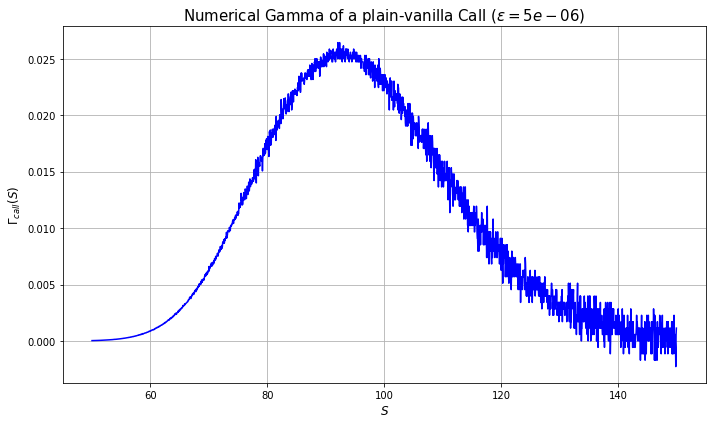

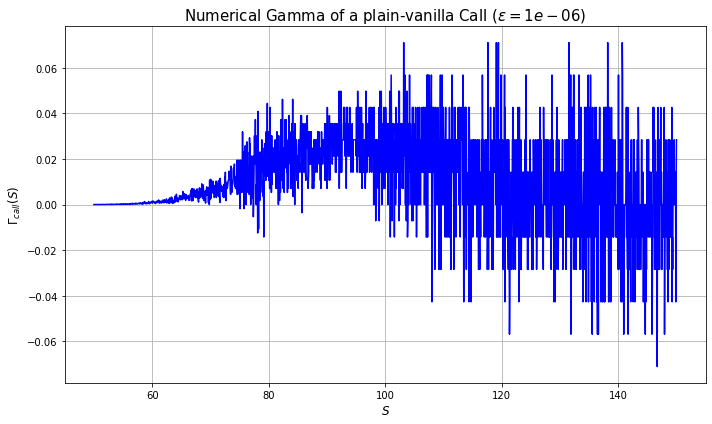

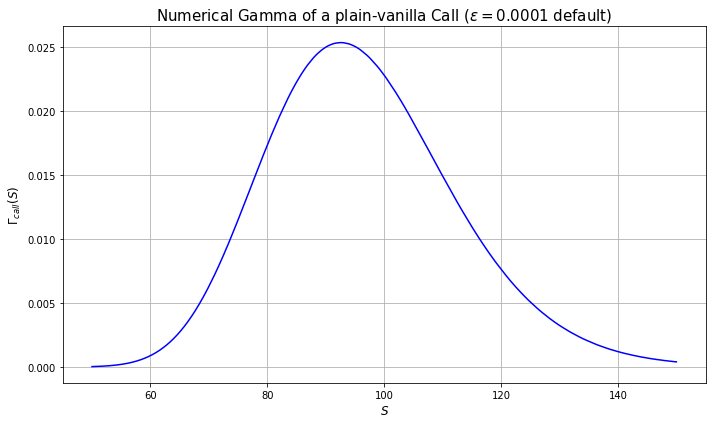

In [26]:
# epsilon reduction: 1e-4 --> 1e-5
NumGreeks.set_epsilon(1e-5)

# numeric gamma
gamma_numerical = NumGreeks.gamma(S0=S)

# gamma plot
plot(x=S, f=gamma_numerical, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
title=r"Numerical Gamma of a plain-vanilla Call ($\epsilon={}$)".format(NumGreeks.get_epsilon()))

# epsilon further reduction: 1e-5 --> 5e-6
NumGreeks.set_epsilon(5e-6)

# numeric gamma
gamma_numerical = NumGreeks.gamma(S0=S)

# gamma plot
plot(x=S, f=gamma_numerical, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
title=r"Numerical Gamma of a plain-vanilla Call ($\epsilon={}$)".format(NumGreeks.get_epsilon()))

# epsilon even further reduction: 1e-5 --> 1e-6
NumGreeks.set_epsilon(1e-6)

# numeric gamma
gamma_numerical = NumGreeks.gamma(S0=S)

# gamma plot
plot(x=S, f=gamma_numerical, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
title=r"Numerical Gamma of a plain-vanilla Call ($\epsilon={}$)".format(NumGreeks.get_epsilon()))

# restoring default value of epsilon
NumGreeks.set_epsilon()

# numeric gamma
gamma_numerical = NumGreeks.gamma(S0=S)

# gamma plot
plot(x=S, f=gamma_numerical, x_label=r"$S$", f_label=r"$\Gamma_{call}(S)$", 
title=r"Numerical Gamma of a plain-vanilla Call ($\epsilon={}$ default)".format(NumGreeks.get_epsilon()))

In [27]:
vega_numerical = NumGreeks.vega(S=S)

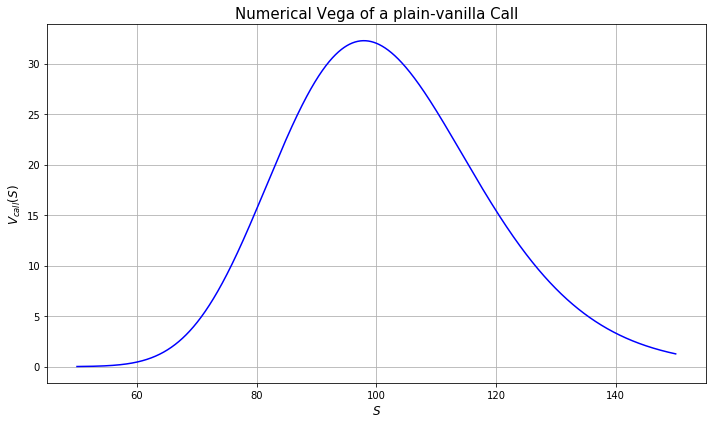

In [28]:
plot(x=S, f=vega_numerical, x_label=r"$S$", f_label=r"$V_{call}(S)$", 
     title=r"Numerical Vega of a plain-vanilla Call")

delta of a put

In [29]:
Vanilla_Put = PlainVanillaOption(mkt_env, option_type="put")

Initializing the EuropeanOption!


In [30]:
NumGreeks = NumericalGreeks(Vanilla_Put)

In [31]:
delta_numerical = NumGreeks.delta(S0=S)

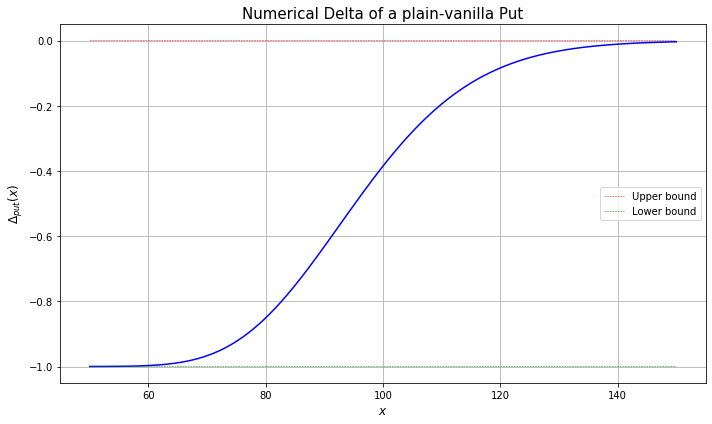

In [32]:
plot(x=S, f=delta_numerical, f_label=r"$\Delta_{put}(x)$", 
     f_up=np.zeros(len(S)), f_up_label=r"Upper bound",
     f_down=-np.ones(len(S)), f_down_label=r"Lower bound",
     title=r"Numerical Delta of a plain-vanilla Put")